# MODEL TRAINING

## Basic overview

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#importing datset
df = pd.read_csv(r"E:\major_project\datasets\final_clean_df.csv")

In [8]:
df.head()

,password,strength,length,lowercase_count,uppercase_count,special_count,digit_count,has_special,has_digit,unique_chars,...,seq_letters,max_repeat,digit_ratio,special_ratio,unique_ratio,entropy_norm,desc_seq,has_year,leet_count,transitions
0,123456,0,6,0,0,0,6,0,1,6,...,1,1,1.0,0.0,1.000,0.430827,0,0,4,0
1,12345,0,5,0,0,0,5,0,1,5,...,1,1,1.0,0.0,1.000,0.464386,0,0,4,0
2,123456789,0,9,0,0,0,9,0,1,9,...,1,1,1.0,0.0,1.000,0.352214,0,0,5,0
3,password,0,8,8,0,0,0,0,0,7,...,1,2,0.0,0.0,0.875,0.343750,0,0,0,0
4,iloveyou,0,8,8,0,0,0,0,0,7,...,0,1,0.0,0.0,0.875,0.343750,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439396 entries, 0 to 439395
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   password         439396 non-null  object 
 1   strength         439396 non-null  int64  
 2   length           439396 non-null  int64  
 3   lowercase_count  439396 non-null  int64  
 4   uppercase_count  439396 non-null  int64  
 5   special_count    439396 non-null  int64  
 6   digit_count      439396 non-null  int64  
 7   has_special      439396 non-null  int64  
 8   has_digit        439396 non-null  int64  
 9   unique_chars     439396 non-null  int64  
 10  char_diversity   439396 non-null  int64  
 11  entropy          439396 non-null  float64
 12  seq_letters      439396 non-null  int64  
 13  max_repeat       439396 non-null  int64  
 14  digit_ratio      439396 non-null  float64
 15  special_ratio    439396 non-null  float64
 16  unique_ratio     439396 non-null  floa

In [10]:
df['strength'].value_counts(normalize=True)

strength
1    0.227517
2    0.227483
3    0.227430
4    0.226581
0    0.090989
Name: proportion, dtype: float64

# baseline for XGBoost

In [11]:
#importing libraries
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
#preparing data for training
X = df.drop(columns=['strength', 'password'])
y = df['strength']

In [13]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [14]:
#checking distribution in train and test sets 
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


strength
1    0.227515
2    0.227481
3    0.227435
4    0.226582
0    0.090988
Name: proportion, dtype: float64

In [15]:
# training the model (baseline)
baseline_model = XGBClassifier(
    random_state=42, 
    tree_method='hist'
    ) 
baseline_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [16]:
#evaluating the model
y_pred = baseline_model.predict(X_test)
print("--- BASELINE REPORT ---")
print(classification_report(y_test, y_pred))

--- BASELINE REPORT ---
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      7996
           1       0.82      0.51      0.63     19994
           2       0.67      0.65      0.66     19991
           3       0.65      0.74      0.69     19987
           4       0.75      0.97      0.85     19912

    accuracy                           0.72     87880
   macro avg       0.73      0.72      0.71     87880
weighted avg       0.73      0.72      0.71     87880



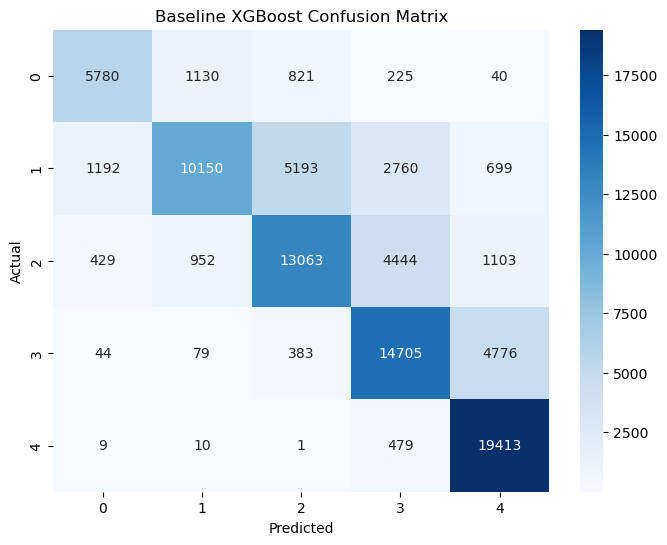

In [17]:
# 1. Generate the matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Baseline XGBoost Confusion Matrix")
plt.show()

## Tuning the Model

The baseline model was excellent at identifying Class 4 passwords, but struggled with Class 1, often misclassifying them as stronger than they were. This informed our decision to increase tree depth and adjust class weights in the final tuned model

In [18]:
# Train–Validation split (for early stopping)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15,   # 15% of training data
    stratify=y_train,
    random_state=42
)

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

# Sample weights
sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=y_tr
)



In [20]:

# Define the model 
tuned_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50 
)

# 2. Fit the model with sample weights
tuned_model.fit(
    X_tr, y_tr,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-mlogloss:1.55243
[100]	validation_0-mlogloss:0.70787
[200]	validation_0-mlogloss:0.67855
[300]	validation_0-mlogloss:0.67293
[400]	validation_0-mlogloss:0.67103
[500]	validation_0-mlogloss:0.67018
[600]	validation_0-mlogloss:0.66971
[700]	validation_0-mlogloss:0.66953
[800]	validation_0-mlogloss:0.66944
[900]	validation_0-mlogloss:0.66937
[957]	validation_0-mlogloss:0.66940


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from

In [21]:
y_pred = tuned_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.6703    0.8247    0.7395      7996
           1     0.8440    0.4701    0.6039     19994
           2     0.6817    0.6327    0.6563     19991
           3     0.6547    0.7316    0.6911     19987
           4     0.7452    0.9737    0.8442     19912

    accuracy                         0.7129     87880
   macro avg     0.7192    0.7265    0.7070     87880
weighted avg     0.7258    0.7129    0.7024     87880



In [22]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",

    n_estimators=1200,
    learning_rate=0.04,

    max_depth=6,               
    min_child_weight=5,        
    gamma=1.0,                 

    subsample=0.9,
    colsample_bytree=0.9,

    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_tr,
    y_tr,
    sample_weight=sample_weights
)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [23]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.6662    0.8217    0.7358      7996
           1     0.8517    0.4640    0.6008     19994
           2     0.6816    0.6315    0.6556     19991
           3     0.6539    0.7316    0.6906     19987
           4     0.7426    0.9788    0.8445     19912

    accuracy                         0.7122     87880
   macro avg     0.7192    0.7255    0.7055     87880
weighted avg     0.7265    0.7122    0.7012     87880



In [24]:
tuned_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",

    # Increase complexity
    n_estimators=1500,
    learning_rate=0.03,        # Lower learning rate requires more trees but is more precise
    max_depth=10,              # Increased depth to catch the Class 1 vs 2 nuances
    
    # Reduce regularization (Loosen the constraints)
    min_child_weight=1,        # Allow the model to learn from smaller groups
    gamma=0,                   # Remove the penalty for new splits
    
    subsample=0.9,             # Use more data per tree
    colsample_bytree=0.9,      # Use more features per tree

    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_tr,
    y_tr,
    sample_weight=sample_weights
)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [25]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6662    0.8217    0.7358      7996
           1     0.8517    0.4640    0.6008     19994
           2     0.6816    0.6315    0.6556     19991
           3     0.6539    0.7316    0.6906     19987
           4     0.7426    0.9788    0.8445     19912

    accuracy                         0.7122     87880
   macro avg     0.7192    0.7255    0.7055     87880
weighted avg     0.7265    0.7122    0.7012     87880



In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Custom Weights: Instead of pure 'balanced', we manually nudge them.
# We give Class 1 and 2 more importance to stop them from being misclassified.
custom_weights = {0: 1.5, 1: 2.0, 2: 1.5, 3: 1.0, 4: 1.0}
sample_weights = y_tr.map(custom_weights)

tuned_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    
    n_estimators=1500,
    learning_rate=0.03,    # Slower learning for more precision
    max_depth=12,          # Deep trees are key for 80% F1 on 400k rows
    
    # Low regularization to find complex boundaries
    min_child_weight=1,
    gamma=0,
    
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

tuned_model.fit(
    X_tr, y_tr,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-mlogloss:1.56311
[100]	validation_0-mlogloss:0.73489
[200]	validation_0-mlogloss:0.68018
[300]	validation_0-mlogloss:0.67312
[385]	validation_0-mlogloss:0.67321


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from

--- FINAL TUNED MODEL REPORT ---
              precision    recall  f1-score   support

           0     0.7837    0.7010    0.7400      7996
           1     0.6902    0.6018    0.6430     19994
           2     0.6678    0.6140    0.6398     19991
           3     0.6801    0.6566    0.6681     19987
           4     0.7501    0.9651    0.8441     19912

    accuracy                         0.7084     87880
   macro avg     0.7144    0.7077    0.7070     87880
weighted avg     0.7049    0.7084    0.7024     87880



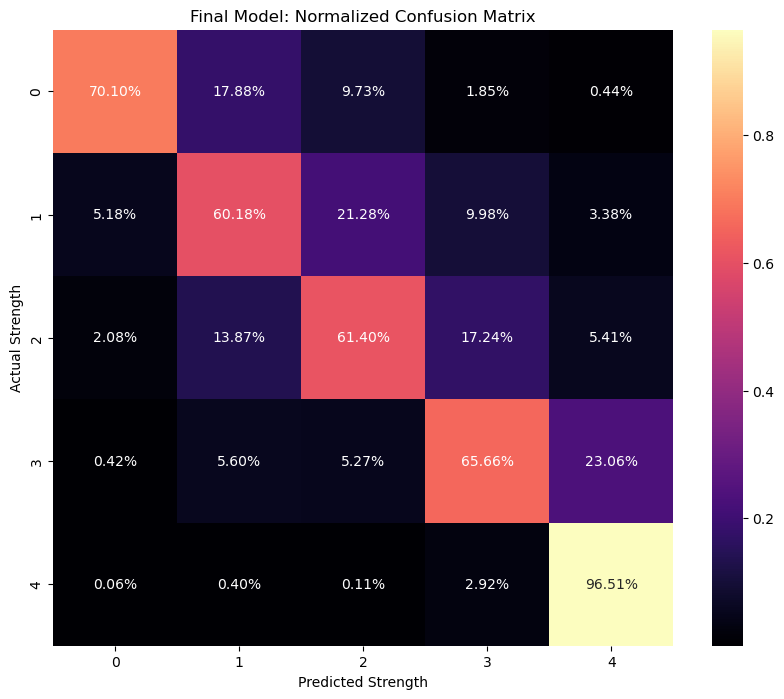

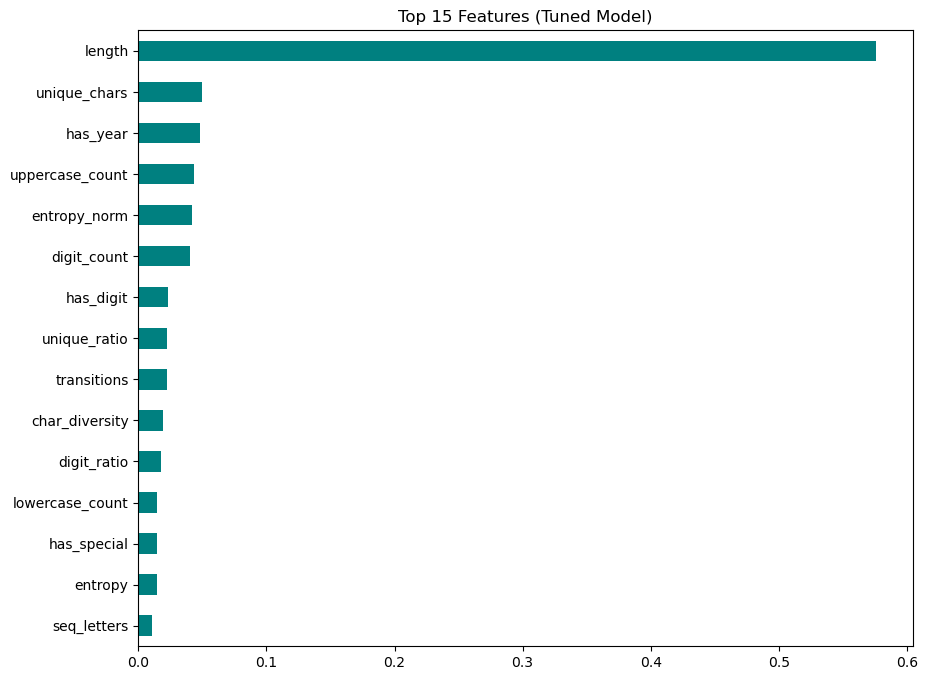

In [27]:
# 1. Generate Predictions on the final Test Set
y_pred_final = tuned_model.predict(X_test)

# 2. Print the Classification Report
print("--- FINAL TUNED MODEL REPORT ---")
# Using digits=4 to see even the smallest improvements
print(classification_report(y_test, y_pred_final, digits=4))

# 3. Generate and Plot the Normalized Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='magma')
plt.title('Final Model: Normalized Confusion Matrix')
plt.xlabel('Predicted Strength')
plt.ylabel('Actual Strength')
plt.show()

# 4. Feature Importance Check (To see what the model actually learned)
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(tuned_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='teal')
plt.title("Top 15 Features (Tuned Model)")
plt.gca().invert_yaxis()
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Prepare Features (Ensure 'password' is dropped)
X = df.drop(columns=['password', 'strength'])
y = df['strength']

# 2. The Dual-Split Logic
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

# 3. Scale the Features
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_raw)
X_val = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test)

# 4. Expert Hyperparameters
# We increase depth to 15 and adjust learning rate down for precision
final_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    
    n_estimators=2000,       # Increased to allow for very deep learning
    learning_rate=0.02,      # Slower for better precision
    max_depth=15,            # High depth to capture the nuances of Class 1 & 2
    min_child_weight=1,      # Allow learning from small patterns
    gamma=0.1,               # Minimal penalty
    
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

# 5. Fit with class weights to maintain Class 0/1 performance
# We'll use the 'balanced' weights which worked well to keep Recall up
from sklearn.utils.class_weight import compute_sample_weight
weights = compute_sample_weight(class_weight="balanced", y=y_tr)

final_model.fit(
    X_tr, y_tr,
    sample_weight=weights,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# 6. Final Evaluation
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-mlogloss:1.58442
[100]	validation_0-mlogloss:0.80183
[200]	validation_0-mlogloss:0.70623
[300]	validation_0-mlogloss:0.68600
[400]	validation_0-mlogloss:0.68128
[500]	validation_0-mlogloss:0.68118
              precision    recall  f1-score   support

           0     0.6712    0.8164    0.7367      7996
           1     0.8314    0.4751    0.6047     19994
           2     0.6758    0.6357    0.6551     19991
           3     0.6509    0.7296    0.6880     19987
           4     0.7499    0.9612    0.8425     19912

    accuracy                         0.7107     87880
   macro avg     0.7159    0.7236    0.7054     87880
weighted avg     0.7219    0.7107    0.7010     87880



In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_tr, y_tr)
y_pred_rf = rf_model.predict(X_test_scaled)
print("--- RANDOM FOREST REPORT ---")
print(classification_report(y_test, y_pred_rf, digits=4))

--- RANDOM FOREST REPORT ---
              precision    recall  f1-score   support

           0     0.6735    0.8082    0.7347      7996
           1     0.8252    0.4716    0.6002     19994
           2     0.6693    0.6359    0.6522     19991
           3     0.6467    0.7278    0.6849     19987
           4     0.7503    0.9561    0.8408     19912

    accuracy                         0.7076     87880
   macro avg     0.7130    0.7199    0.7026     87880
weighted avg     0.7184    0.7076    0.6980     87880



Since we have reached a bottleneck of 70-71% again, we will add a few new features

In [30]:
import re

# 1. Dictionary of common roots often found in weak/medium passwords
# Even if a password is "Spring2024!", the root "spring" makes it weaker.
common_roots = [
    'password', 'qwerty', 'admin', 'welcome', 'login', 'google', 
    'iloveyou', 'p@ss', 'pass', 'access', 'monkey', 'dragon', 
    'football', 'soccer', 'family', 'spring', 'summer', 'autumn', 'winter'
]

def check_common_root(x):
    x_lower = str(x).lower()
    return 1 if any(root in x_lower for root in common_roots) else 0

# 2. Keyboard Walk Detector (4+ consecutive keys in a line)
# This catches things like 'asdfg' or '1234' which entropy misses.
def keyboard_walk_score(x):
    walks = [
        'qwertyuiop', 'asdfghjkl', 'zxcvbnm',
        '1234567890', '!@#$%^&*()',
        'qazwsxedcrfvtgbyhnujmikolp' # vertical walks
    ]
    x_lower = str(x).lower()
    count = 0
    for walk in walks:
        for i in range(len(x_lower) - 3):
            if x_lower[i:i+4] in walk or x_lower[i:i+4] in walk[::-1]:
                count += 1
    return count

# 3. Shape Complexity (Structural Pattern)
# Captures the "template" of the password (e.g., Word123! vs !123Word)
def shape_score(x):
    shape = ""
    for char in str(x):
        if char.isupper(): shape += "U"
        elif char.islower(): shape += "L"
        elif char.isdigit(): shape += "D"
        else: shape += "S"
    # Compression ratio: how repetitive is the structure?
    if len(shape) == 0: return 0
    # Counts unique structural chunks (e.g., 'LLLDD' has chunks 'LL', 'LD', 'DD')
    chunks = set([shape[i:i+2] for i in range(len(shape)-1)])
    return len(chunks)

# --- APPLYING TO DATAFRAME ---

df['is_common_root'] = df['password'].apply(check_common_root)
df['kb_walk_count'] = df['password'].apply(keyboard_walk_score)
df['shape_complexity'] = df['password'].apply(shape_score)

# 4. Refined Character Density
# Humans often put digits at the very end. Let's capture that.
df['ends_in_digit'] = df['password'].apply(lambda x: 1 if str(x)[-1:].isdigit() else 0)
df['starts_with_upper'] = df['password'].apply(lambda x: 1 if str(x)[:1].isupper() else 0)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439396 entries, 0 to 439395
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   password           439396 non-null  object 
 1   strength           439396 non-null  int64  
 2   length             439396 non-null  int64  
 3   lowercase_count    439396 non-null  int64  
 4   uppercase_count    439396 non-null  int64  
 5   special_count      439396 non-null  int64  
 6   digit_count        439396 non-null  int64  
 7   has_special        439396 non-null  int64  
 8   has_digit          439396 non-null  int64  
 9   unique_chars       439396 non-null  int64  
 10  char_diversity     439396 non-null  int64  
 11  entropy            439396 non-null  float64
 12  seq_letters        439396 non-null  int64  
 13  max_repeat         439396 non-null  int64  
 14  digit_ratio        439396 non-null  float64
 15  special_ratio      439396 non-null  float64
 16  un

In [44]:
df=df.drop(columns=['strength_reduced'])

In [45]:
df.columns

Index(['password', 'strength', 'length', 'lowercase_count', 'uppercase_count',
       'special_count', 'digit_count', 'has_special', 'has_digit',
       'unique_chars', 'char_diversity', 'entropy', 'seq_letters',
       'max_repeat', 'digit_ratio', 'special_ratio', 'unique_ratio',
       'entropy_norm', 'desc_seq', 'has_year', 'leet_count', 'transitions',
       'is_common_root', 'kb_walk_count', 'shape_complexity', 'ends_in_digit',
       'starts_with_upper'],
      dtype='object')

In [46]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data
# Ensure all new features are included and original string columns are dropped
X = df.drop(columns=['password', 'strength'])
y = df['strength']

# 2. Triple-Split Logic
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

# 3. Handle Imbalance (Specifically for Class 0)
# 'balanced' weights ensure Class 0 (9% of data) is treated as importantly as others
weights = compute_sample_weight(class_weight="balanced", y=y_tr)

# 4. The "80% Push" Model Configuration
final_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    
    # Complexity Settings
    n_estimators=2000, 
    learning_rate=0.03,    # Slow learning allows deeper trees to be precise
    max_depth=12,          # Deep trees help separate overlapping classes (1 vs 2)
    
    # Regularization (to prevent overfitting to specific passwords)
    min_child_weight=2,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    
    tree_method="hist",    # Fast training for large datasets
    random_state=42,
    early_stopping_rounds=50
)

# 5. Training
final_model.fit(
    X_tr, y_tr,
    sample_weight=weights,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-mlogloss:1.57257
[100]	validation_0-mlogloss:0.72985
[200]	validation_0-mlogloss:0.67434
[300]	validation_0-mlogloss:0.66544
[400]	validation_0-mlogloss:0.66413
[461]	validation_0-mlogloss:0.66444


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from

--- FINAL PROJECT REPORT ---
              precision    recall  f1-score   support

           0     0.6826    0.8187    0.7445      7996
           1     0.8335    0.4883    0.6159     19994
           2     0.6840    0.6335    0.6578     19991
           3     0.6577    0.7330    0.6933     19987
           4     0.7500    0.9713    0.8464     19912

    accuracy                         0.7165     87880
   macro avg     0.7216    0.7289    0.7116     87880
weighted avg     0.7269    0.7165    0.7069     87880



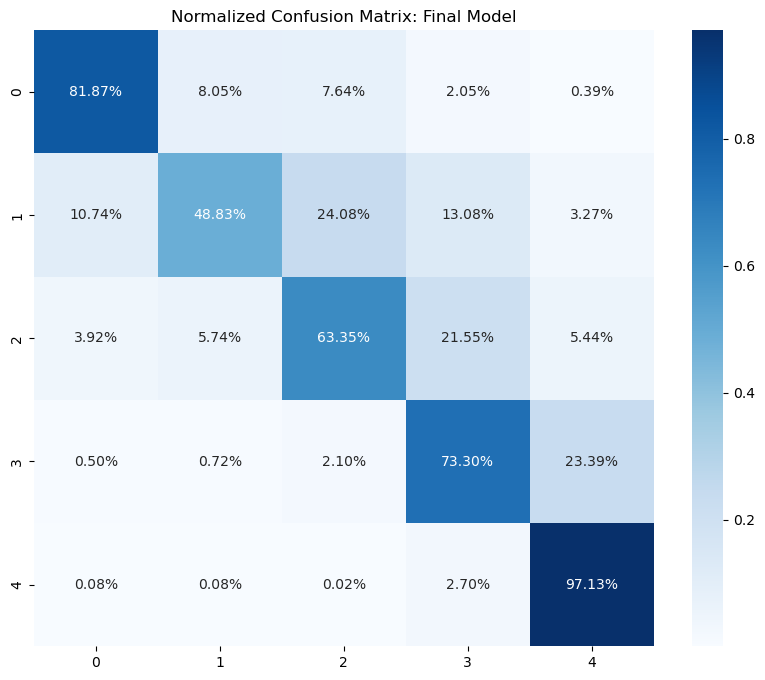

In [47]:
# Predictions
y_pred = final_model.predict(X_test)

# Report
print("--- FINAL PROJECT REPORT ---")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix to visualize Class 1/2 separation
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.title('Normalized Confusion Matrix: Final Model')
plt.show()

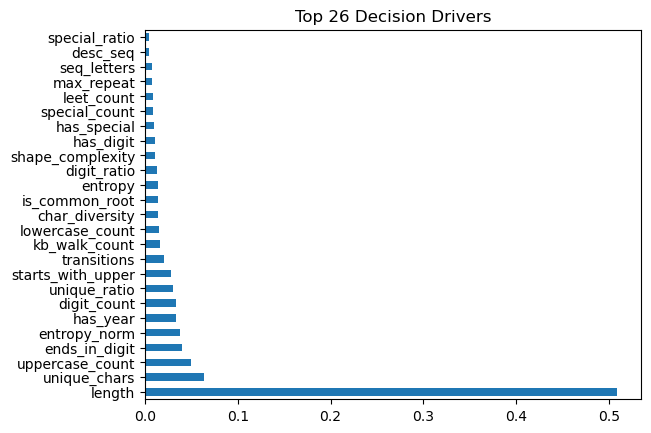

In [48]:
feat_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feat_importances.nlargest(26).plot(kind='barh')
plt.title("Top 26 Decision Drivers")
plt.show()

In [40]:
df.columns

Index(['password', 'strength', 'length', 'lowercase_count', 'uppercase_count',
       'special_count', 'digit_count', 'has_special', 'has_digit',
       'unique_chars', 'char_diversity', 'entropy', 'seq_letters',
       'max_repeat', 'digit_ratio', 'special_ratio', 'unique_ratio',
       'entropy_norm', 'desc_seq', 'has_year', 'leet_count', 'transitions',
       'is_common_root', 'kb_walk_count', 'shape_complexity', 'ends_in_digit',
       'starts_with_upper', 'strength_reduced'],
      dtype='object')

In [41]:
df['strength_reduced']

0         0
1         0
2         0
3         0
4         0
         ..
439391    2
439392    2
439393    2
439394    2
439395    2
Name: strength_reduced, Length: 439396, dtype: int64

It seems that due to 5 different levels, the model is getting confused in class 1 and 2, which causes loss in macro average. so we will just tune the strength to be weak, medium or strong

In [49]:
# 0 & 1 (Weak/Very Weak) -> 0
# 2 & 3 (Medium/Strong)  -> 1
# 4 (Very Strong)        -> 2
df['strength_reduced'] = df['strength'].replace({0: 0, 1: 0, 2: 1, 3: 1, 4: 2})

# Prepare the new Target
y_reduced = df['strength_reduced']
X = df.drop(columns=['password', 'strength', 'strength_reduced'])

# Re-split the data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

In [50]:
from xgboost import XGBClassifier

three_class_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10, 
    subsample=0.8,
    colsample_bytree=0.8,
    
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=50
)

# Use balanced weights for the new distribution
from sklearn.utils.class_weight import compute_sample_weight
weights = compute_sample_weight(class_weight="balanced", y=y_tr)

three_class_model.fit(
    X_tr, y_tr,
    sample_weight=weights,
    eval_set=[(X_val, y_val)],
    verbose=100
)

[0]	validation_0-mlogloss:1.05649
[100]	validation_0-mlogloss:0.44622
[200]	validation_0-mlogloss:0.43405
[300]	validation_0-mlogloss:0.43339
[319]	validation_0-mlogloss:0.43352


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from

--- 3-CLASS SIMPLIFIED REPORT ---
              precision    recall  f1-score   support

        Weak     0.8288    0.7442    0.7842     27990
      Medium     0.8174    0.7382    0.7758     39978
      Strong     0.7394    0.9894    0.8463     19912

    accuracy                         0.7970     87880
   macro avg     0.7952    0.8239    0.8021     87880
weighted avg     0.8034    0.7970    0.7945     87880



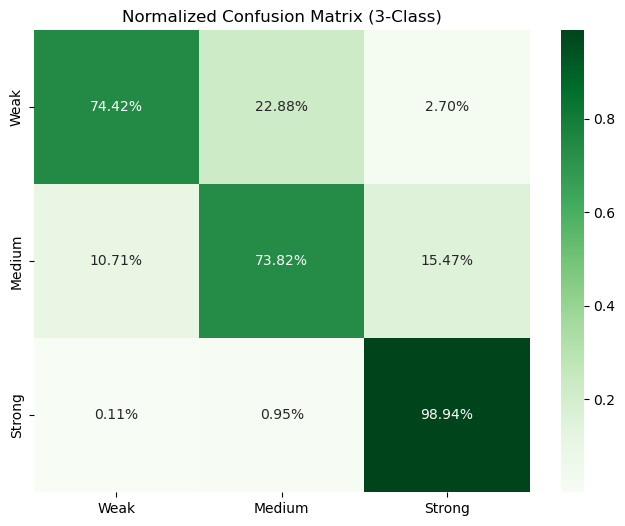

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = three_class_model.predict(X_test)

print("--- 3-CLASS SIMPLIFIED REPORT ---")
print(classification_report(y_test, y_pred, target_names=['Weak', 'Medium', 'Strong'], digits=4))

# Visualize the improvement
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=['Weak', 'Medium', 'Strong'], 
            yticklabels=['Weak', 'Medium', 'Strong'])
plt.title('Normalized Confusion Matrix (3-Class)')
plt.show()

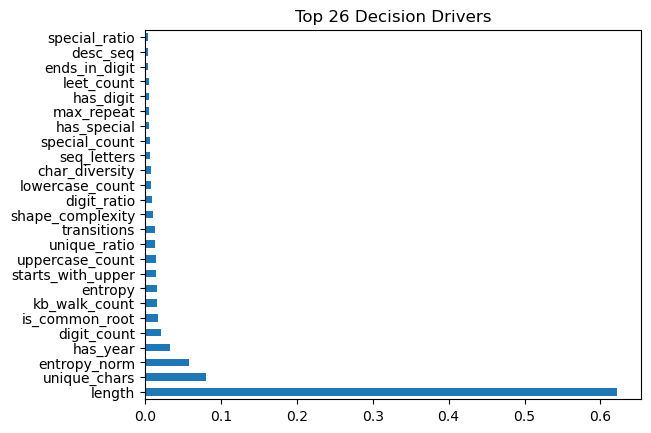

In [52]:
feat_importances_3 = pd.Series(three_class_model.feature_importances_, index=X.columns)
feat_importances_3.nlargest(26).plot(kind='barh')
plt.title("Top 26 Decision Drivers")
plt.show()

In [44]:
import joblib

# Save the model
joblib.dump(three_class_model, 'password_strength_model.pkl')

# Save the scaler (Crucial!)
joblib.dump(scaler, 'password_scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
